In [ ]:
!kaggle datasets download emirhanyldz/chest-xray

Dataset URL: https://www.kaggle.com/datasets/emirhanyldz/chest-xray
License(s): CC0-1.0
100% 2.11G/2.11G [01:40<00:00, 22.9MB/s]
100% 2.11G/2.11G [01:40<00:00, 22.6MB/s]


In [ ]:
!unzip chest-xray.zip -d chest-xray

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: chest-xray/images/00003122_017.png  
  inflating: chest-xray/images/00003124_000.png  
  inflating: chest-xray/images/00003129_000.png  
  inflating: chest-xray/images/00003129_001.png  
  inflating: chest-xray/images/00003129_004.png  
  inflating: chest-xray/images/00003129_009.png  
  inflating: chest-xray/images/00003129_011.png  
  inflating: chest-xray/images/00003135_000.png  
  inflating: chest-xray/images/00003140_007.png  
  inflating: chest-xray/images/00003159_001.png  
  inflating: chest-xray/images/00003169_001.png  
  inflating: chest-xray/images/00003177_002.png  
  inflating: chest-xray/images/00003186_004.png  
  inflating: chest-xray/images/00003186_005.png  
  inflating: chest-xray/images/00003190_018.png  
  inflating: chest-xray/images/00003191_001.png  
  inflating: chest-xray/images/00003198_002.png  
  inflating: chest-xray/images/00003198_005.png  
  inflating: chest-xray/images/00003198_009.png  
  i

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

csv_file = "/content/chest-xray/labels.csv"
image_dir = "/content/chest-xray/images"

df = pd.read_csv(csv_file)

In [ ]:
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

all_labels = set(label for labels in df['Finding Labels'] for label in labels)

all_labels.remove('No Finding')

for label in all_labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)


In [ ]:
columns = ["Image Index", "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
          "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema",
          "Fibrosis", "Pleural_Thickening", "Hernia"]

filtered_df = df[columns]

train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

image_dir = "/content/chest-xray/images/" 

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from tensorflow.keras.metrics import AUC

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(14, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=output)
"""
for layer in base_model.layers:
    layer.trainable = False
"""

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='roc_auc', multi_label=True)])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,341,966 (28.01 MB)

 Trainable params: 7,258,318 (27.69 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
import tensorflow as tf

device_name = tf.config.list_physical_devices('GPU')
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("No GPU detected. Running on CPU.")

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
img_size = 224
train_batch_size = 16
val_batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="Image Index",
    y_col=list(all_labels),
    class_mode="raw",
    target_size=(img_size, img_size),
    batch_size=train_batch_size,
    shuffle=True,
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="Image Index",
    y_col=list(all_labels),
    class_mode="raw",
    target_size=(img_size, img_size),
    batch_size=val_batch_size,
    subset="validation"
)


Found 3588 validated image filenames.
Found 896 validated image filenames.


In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        verbose=1
        )


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.0755 - loss: 0.3798 - roc_auc: 0.5124 - val_accuracy: 0.1105 - val_loss: 0.1867 - val_roc_auc: 0.6076
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 155s 690ms/step - accuracy: 0.1149 - loss: 0.2080 - roc_auc: 0.5693 - val_accuracy: 0.1183 - val_loss: 0.1776 - val_roc_auc: 0.6519
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 152s 677ms/step - accuracy: 0.1192 - loss: 0.1992 - roc_auc: 0.5970 - val_accuracy: 0.1172 - val_loss: 0.1761 - val_roc_auc: 0.6704
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 201s 671ms/step - accuracy: 0.1195 - loss: 0.1944 - roc_auc: 0.5999 - val_accuracy: 0.1384 - val_loss: 0.1717 - val_roc_auc: 0.6704
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 152s 674ms/step - accuracy: 0.1321 - loss: 0.1865 - roc_auc: 0.6439 - val_accuracy: 0.1384 - val_loss: 0.1715 - val_roc_auc: 0.6694
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 678ms/step - accuracy: 0.1304 - loss: 0.1832 - roc_auc: 0.6685 - val_accuracy: 0.1417 - val_loss: 

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col="Image Index",
    y_col=list(all_labels),
    class_mode="raw",
    target_size=(img_size, img_size),
    batch_size=16,
    shuffle=False
)

predictions = model.predict(test_generator)

y_true = test_df[list(all_labels)].values
roc_auc_scores = {label: roc_auc_score(y_true[:, idx], predictions[:, idx])
                  for idx, label in enumerate(all_labels)}

for label, score in roc_auc_scores.items():
    print(f"{label}: ROC-AUC = {score:.4f}")


Found 1122 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 565ms/step
Emphysema: ROC-AUC = 0.8416
Cardiomegaly: ROC-AUC = 0.7129
Pleural_Thickening: ROC-AUC = 0.6903
Fibrosis: ROC-AUC = 0.6635
Pneumothorax: ROC-AUC = 0.8034
Hernia: ROC-AUC = 0.4114
Effusion: ROC-AUC = 0.8007
Infiltration: ROC-AUC = 0.6433
Atelectasis: ROC-AUC = 0.7644
Nodule: ROC-AUC = 0.6320
Pneumonia: ROC-AUC = 0.6329
Edema: ROC-AUC = 0.7994
Mass: ROC-AUC = 0.6603
Consolidation: ROC-AUC = 0.7131


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img_size = 224

labels = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
          "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema",
          "Fibrosis", "Pleural_Thickening", "Hernia"]

image_dir = "/content/chest-xray/images"

def predict_with_model(model, image_path, img_size, labels):
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    results = {labels[i]: predictions[0][i] for i in range(len(labels))}
    return results

def evaluate_random_sample(model, df, image_dir, img_size, labels, sample=2):

    predicted_labels ={}
    true_labels = {}
    image_paths = []
    for _ in range(sample):
        random_sample = df.sample().iloc[0]
        image_path = f"{image_dir}/{random_sample['Image Index']}"
        image_paths.append(image_path)

        output = predict_with_model(model, image_path, img_size, labels)
        for key, value in output.items():
            predicted_labels[key].append(value) if key in predicted_labels else predicted_labels.update({key: [value]})
            true_labels[key].append(random_sample[key]) if key in true_labels else true_labels.update({key: [random_sample[key]]})
    """
    print("Gerçek Etiketler:")
    for label, value in true_labels.items():
        print(f"{label}: {value}")

    print("\nTahmin Edilen Etiketler:")
    for label, prob in predicted_labels.items():
        print(f"{label}: {prob:.4f}")
    """
    return image_paths, true_labels, predicted_labels

image_paths, true_labels, predicted_labels = evaluate_random_sample(model, df, image_dir, img_size, labels, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [ ]:
for value in true_labels.values():
    print(value)

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]


In [ ]:
for value in predicted_labels.values():
    print(value)

[5.7316494e-05, 8.505864e-05, 0.15018336, 0.056016836, 0.02295735]
[0.00040367103, 0.0020651086, 0.0037955767, 0.21687305, 0.024222827]
[0.0007211585, 0.00039535805, 0.03130439, 0.09560209, 0.021577213]
[9.283796e-05, 0.0011274688, 0.024728704, 0.062325533, 0.0118882]
[0.000346081, 0.00014405299, 0.5957167, 0.057753444, 0.015420416]
[6.6167318e-06, 3.9791112e-07, 0.0013810581, 0.027766773, 0.00083597325]
[0.0008313959, 0.0013026547, 0.044222575, 0.0798134, 0.02533097]
[0.41177914, 0.0026223264, 0.04518939, 0.20501696, 0.13146663]
[0.000370845, 0.0018745485, 0.11547376, 0.24185209, 0.02998575]
[0.004372633, 0.0005519055, 0.02805867, 0.19488162, 0.018095793]
[4.7730784e-05, 3.701684e-05, 0.0026159436, 0.0635709, 0.00826597]
[0.00032082212, 0.0006924005, 0.0012547983, 0.043411795, 0.010196385]
[0.0003121084, 0.00012285194, 0.030926008, 0.096763015, 0.010807534]
[0.0013373729, 0.00026507737, 0.010110138, 0.100455195, 0.010855026]


In [ ]:
for path in image_paths:
    print(path)

/content/chest-xray/images/00023816_000.png
/content/chest-xray/images/00006195_007.png
/content/chest-xray/images/00009231_008.png
/content/chest-xray/images/00018027_007.png
/content/chest-xray/images/00016469_000.png


In [ ]:
model.save_weights('model.weights.h5')
model.save('complete_model.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_attention_map_for_class(model, img_array, attention_layer_name, class_index):
    attention_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(attention_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = attention_model(img_array)

        if predictions is None or tf.reduce_max(predictions) == 0:
            raise ValueError("Model çıktıları geçersiz! Lütfen modelin tahmin değerlerini kontrol edin.")

        class_output = predictions[:, class_index]
        if class_output is None or tf.reduce_max(class_output) == 0:
            raise ValueError(f"Belirtilen sınıf ({class_index}) için tahmin değeri bulunamadı.")

        tape.watch(conv_outputs)

    grads = tape.gradient(class_output, conv_outputs)
    if grads is None:
        raise ValueError("Gradient hesaplanamadı. Lütfen modelin katman ve loss yapısını kontrol edin.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    attention_map = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    attention_map = np.maximum(attention_map, 0) / (np.max(attention_map) + 1e-8)
    return attention_map


def display_attention_maps(img_path, img_array, model, attention_layer_name, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 1) // 2, ncols=2, figsize=(12, num_classes * 2))
    axes = axes.flatten()

    for class_index, class_name in enumerate(class_names):
        attention_map = get_attention_map_for_class(model, img_array, attention_layer_name, class_index)

        img = load_img(img_path)
        img = img_to_array(img)

        attention_map_resized = tf.image.resize(attention_map[..., np.newaxis], (img.shape[0], img.shape[1]))
        attention_map_resized = np.squeeze(attention_map_resized)

        heatmap = plt.cm.jet(attention_map_resized)[:, :, :3]

        alpha = 0.6
        superimposed_img = heatmap * 255 * alpha + img * (1 - alpha)
        superimposed_img = np.uint8(superimposed_img)

        ax = axes[class_index]
        ax.imshow(superimposed_img)
        ax.set_title(f"Class: {class_name}")
        ax.axis('off')

    for i in range(class_index + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



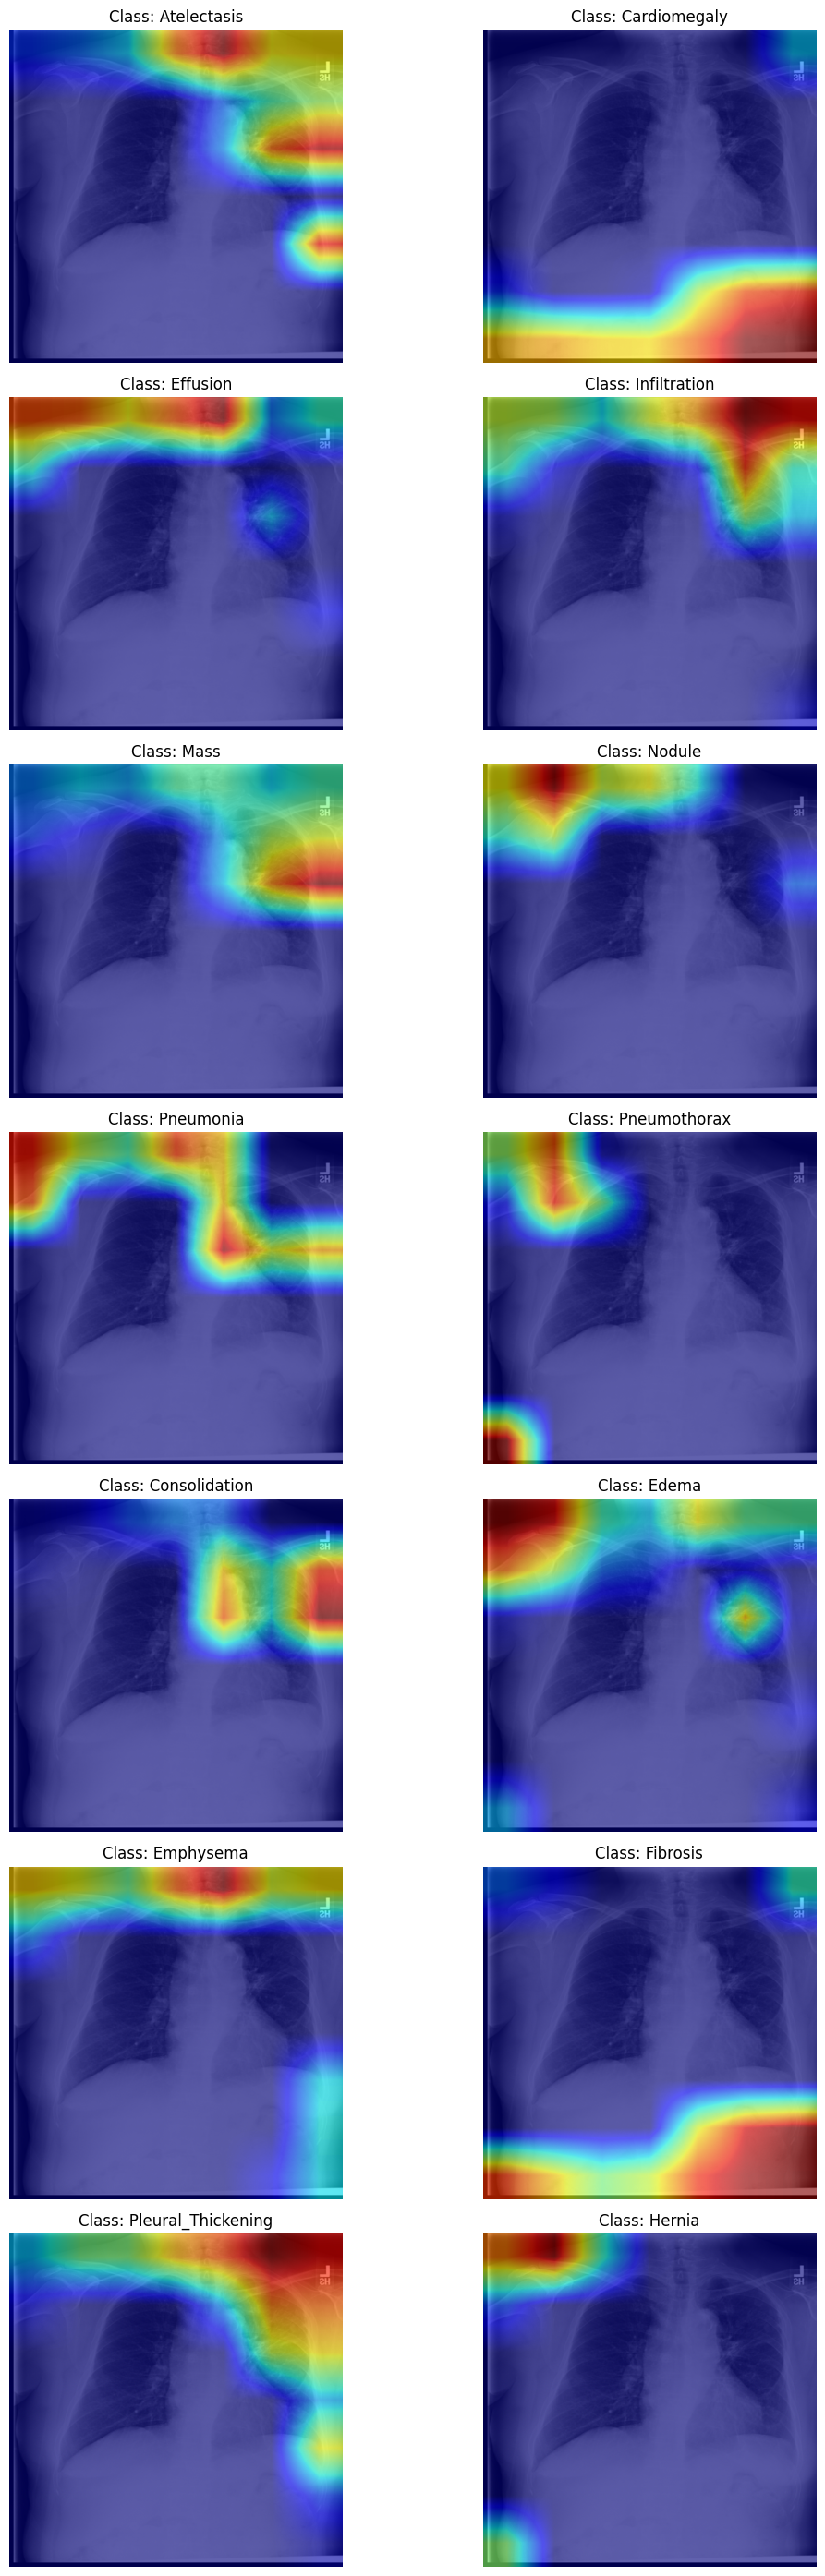

In [ ]:

image_path = "/content/chest-xray/images/00018027_007.png"  

attention_layer_name = "conv5_block16_concat" 

img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

class_names = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
               'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
               'Pleural_Thickening', 'Hernia']

display_attention_maps(image_path, img_array, model, attention_layer_name, labels)